# Laboratorio ERF - RASCUNHO

>Trabalho Prático n.º 5

## Projecto de um filtro passa-banda

>[!question]1. Projecte um filtro passa-banda com as seguintes características:
>- Impedância característica $Z_0=50 \Omega$.
>- Banda $L$ ou $S$ (com largura de banda inferior a 20%).
>- $20\ dB$ de atenuação a 15% da frequência central $f_c$.
>- Perdas por inserção inferiores a $3\ dB$.
>- __Laminado__: Rogers, RO4003C ($H=0.508mm$,$\epsilon_r=3.55$, $tan_D=0.0021$)


>[!question]a) Escolha um tipo de filtro (equal-ripple, maximally flat ou maximally flat time delay) justificando com uma possível aplicação prática para o filtro projectado.

A banda S contém o espectro do sinal de Wifi, por isso para ter um objectivo pratico, vamos tentar criar um filtro para wifi 2.4ghz.
entre 2.4 ghz e 2.835ghz que engloba o standart 802.11 do IEE, para um total de largura de banda de 16,62%

Para o tipo de codificação digital do wifi, o filtro ideal seria um filtro de Bessel-Thompson, pois este filtro tem um um time delay constante significando que todas as frequencias que compoem o sinal digital que pretendemos que passe pelo nosso filtro nao sofram de atrasos, o que nao acontece com os outros filtros. Esta vantagem tem como reverso da medelha um declive muito lento na zona de corte o que nos impediu de calcular um filtro que cumprisse o requesito de 20dB de atenuação a 15% da banda central. Deparados com esta dificuldade e depois de consultar alguns livros, decidimos projectar um filtro de ordem 3 de Tchebysheb, que cumpre todos os requesitos no entanto apresenta um ripple na banda passante.

In [ ]:
%pip install scikit-rf
%pip install matplotlib
%pip install networkx
%pip install control


In [2]:
import skrf as rf
import numpy as np  # for np.allclose() to check that S-params are similar
import control
from scipy import signal
import matplotlib.pyplot as plt
from IPython.display import display, Markdown, Latex

%matplotlib inline
rf.stylely()


# Contexto Teorico

> IEEE Convention
>
> - $L$ band - $[1,2[\ Ghz$
>
> - $S$ band - $[2,4[\ Ghz$


## [S Band](https://en.wikipedia.org/wiki/S_band)

>The S band is a designation by the Institute of Electrical and Electronics Engineers (IEEE) for a part of the microwave band of the electromagnetic spectrum covering frequencies from 2 to 4 gigahertz (GHz).
>The S band also contains the 2.4–2.483 GHz ISM band, widely used for low power unlicensed microwave devices such as cordless phones, wireless headphones (Bluetooth), wireless networking (WiFi), garage door openers, keyless vehicle locks, baby monitors as well as for medical diathermy machines and microwave ovens (typically at 2.495 GHz).

Given this quote from wikipedia we can see that the S Band is higly populated and since wifi routers working on this band are ubiquitous making it the perfect candidate for a pratical use of a filter the application should be rather easy.

## [Wifi](https://en.wikipedia.org/wiki/List_of_WLAN_channels#2.4_GHz_(802.11b/g/n/ax))

From this article we can se that the 802.11b/g/n/ax IEEE standard operates between 2.4 ghz and 2.5 ghz (2.835ghz exactly).
We can use this to calculate the fraccionary band need for our filter.

$$





## [Bessel polynomials](https://en.wikipedia.org/wiki/Bessel_filter#Bessel_Polynomials)

The transfer function of the Bessel filter is a rational function whose denominator is a reverse Bessel polynomial, such as the following:

$n = 1: s + 1 $

$n = 2: s^{2} + 3s + 3 $

$n = 3: s^{3} + 6s^{2} + 15s + 15 $

$n = 4: s^{4} + 10s^{3} + 45s^{2} + 3s + 3 $

$n = 5: s^{5} + 15s^{4} + 105s^{3} + 420s^{2} + 945s + 945 $

The reverse Bessel polynomials are given by:

$$\theta_{n}(s) = \sum_{k=0}^{n}a_{k}s^{k},$$

where

$$a_{k}= \frac{(2n-k)!}{2^{n-k}k!(n-k)!}\ ,\ k=0,1,...,n$$

given this we will implement a function that `returns` a array with all coefficients from a desired order 

# Bessel Filter
A Bessel low-pass filter is characterized by its transfer function:

$$H(s)=\frac{\theta _{n}(0)}{\theta _{n}(s/\omega _{0})}$$

where $\theta _{n}(s)$ is a reverse Bessel polynomial from which the filter gets its name and $\omega _{0}$ is a frequency chosen to give the desired cut-off frequency. The filter has a low-frequency group delay of $1/\omega _{0}$. Since $\theta _{n}(0)$ is indeterminate by the definition of reverse Bessel polynomials, but is a removable singularity, it is defined that $\theta _{n}(0)=\lim _{{x\rightarrow 0}}\theta _{n}(x)$. This corresponds to the numerator being the independent term in the Bessel polynomial.

In [8]:

import math


def besselpoly(n: int):
    if (n == 0):
        display(Markdown(f"$Order\ must\ be\ bigger\ than\ 0,\tn > 0$"))
        return 0
    poly = []
    string = []
    theta = ""
    for k in range(0, n+1):  # Account for iteration k=n
        a_k = math.factorial(2*n - k) / (pow(2, (n-k)) *
                                         math.factorial(k) * math.factorial(n-k))
        poly.append(a_k)
        string.append(f" - ${k = },a_{k} = {a_k}$")
        aux = f'{a_k:.0f}'
        if a_k == 1 and k != 0:
            aux = ''
        if k > 0:
            if k == 1:
                theta = (aux + 's + ' + theta)
            else:
                theta = (aux+'s^'+'{'+f'{k:.0f}'+'} + ' + theta)
        else:
            theta = ' ' + aux + theta
    display(Markdown(f'${n = }\ ,\ {theta} $'))
    # for line in string:
    #    display(Markdown(line))
    return poly


$n = 3\ ,\ s^{3} + 6s^{2} + 15s +  15 $


              1
-----------------------------
0.06667 s^3 + 0.4 s^2 + s + 1



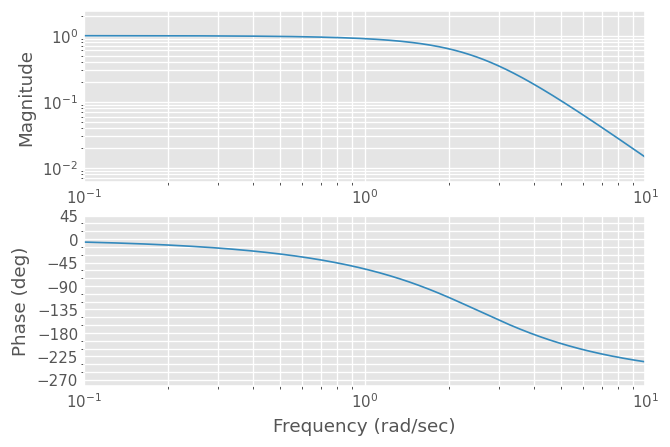

In [9]:
def besselfilter(n):
    poly = besselpoly(n)

    dividend = poly[0]
    poly.reverse()
    for k in range(len(poly)):
        poly[k] = poly[k]/dividend
    H = control.tf(1, poly)
    print(H)
    control.bode(H)
besselfilter(3)


In [3]:

z0 = 50  # Impedancia Caracteristicas
H = 0.508e-3  # (m) Altura do material
e_r = 3.55  # Permissividade
tan_D = 0.0021


wifimax = 2.835
wifimin = 2.4
wifigeocenter = np.sqrt(wifimax*wifimin)
wifiaricenter = 0.5*(wifimax+wifimin)
bwpercent = np.min([(wifimax-wifimin)/wifiaricenter, 0.2]) # a largura de banda tem que ser no maximo 20%


bwmax = ((4e9-2e9)*0.2)
SIM_Steps = 10000

f_c = wifigeocenter  # Hz Frequencia centra para wifi 2.4


f_l = (1 - bwpercent/2) * f_c
f_r = (1 + bwpercent/2) * f_c

w_l = 2*np.pi*f_l
w_r = 2*np.pi*f_r
w_c = 2*np.pi*f_c

w_0 = np.sqrt(w_l*w_r)

w_normalized = 1 / (bwpercent*((f_l/f_c)+(f_c/f_l)))


In [10]:
display(Markdown(f"- Frequencia de atenuaçao normalizada = ${w_normalized:.4}\ $"))
display(Markdown(f"- Largura de Banda Maxima -> $bw_{{max}} = {bwmax:.2e}\ Hz $"))
display(Markdown(f"- Largura de Banda fraccionária -> $bw_{{\%}} = {bwpercent*100:.2f}\ \% $"))
display(Markdown(f"- Frequencia central -> $f_c = {f_c:.2e}\ Hz $"))
display(Markdown(f"- Frequencia angular central (media geometrica)-> $w_0 = {w_0:.2e}\ rad/s$"))
display(Markdown(f"- Frequencia angular central (media aritmetica)-> $w_c = {w_c:.2e}\ rad/s$"))
display(Markdown(f"- Frequencia de corte $f_{{c1}} = {f_l:.2e}\ Hz $"))
display(Markdown(f"- Frequencia de corte $f_{{c2}} = {f_r:.2e}\ Hz $"))
display(Markdown(f"- Frequencia de angular corte $f_{{c1}} = {w_l:.2e}\ rad/s$"))
display(Markdown(f"- Frequencia de angular corte $f_{{c2}} = {w_r:.2e}\ rad/s$"))

- Frequencia de atenuaçao normalizada = $2.997\ $

- Largura de Banda Maxima -> $bw_{max} = 4.00e+08\ Hz $

- Largura de Banda fraccionária -> $bw_{\%} = 16.62\ \% $

- Frequencia central -> $f_c = 2.61e+00\ Hz $

- Frequencia angular central (media geometrica)-> $w_0 = 1.63e+01\ rad/s$

- Frequencia angular central (media aritmetica)-> $w_c = 1.64e+01\ rad/s$

- Frequencia de corte $f_{c1} = 2.39e+00\ Hz $

- Frequencia de corte $f_{c2} = 2.83e+00\ Hz $

- Frequencia de angular corte $f_{c1} = 1.50e+01\ rad/s$

- Frequencia de angular corte $f_{c2} = 1.78e+01\ rad/s$

b) Projecte e simule um protótipo do filtro usando elementos discretos
(condensadores e bobines).


In [ ]:
# scikit-rf: the filter by cascading all lumped-elements
freq = rf.Frequency(0.001, 4, SIM_Steps, 'ghz')
line = rf.media.DefinedGammaZ0(frequency=freq, z0=z0)

# scikit-rf: the filter with the Circuit builder

line = rf.media.DefinedGammaZ0(frequency=freq)
C1 = line.capacitor(11.31e-12, name='C1')
C2 = line.capacitor(217.9e-15, name='C2')
C3 = line.capacitor(16.85e-12, name='C3')
C4 = line.capacitor(217.9e-12, name='C4')
C5 = line.capacitor(11.31e-12, name='C5')
L1 = line.inductor(392.7e-12, name='L1')
L2 = line.inductor(20.39e-9, name='L2')
L3 = line.inductor(263.6e-12, name='L3')
L4 = line.inductor(20.396e-9, name='L5')
L5 = line.inductor(392.7e-12, name='L5')
port1 = rf.Circuit.Port(frequency=freq, name='port1', z0=z0)
port2 = rf.Circuit.Port(frequency=freq, name='port2', z0=z0)
ground = rf.Circuit.Ground(frequency=freq, name='ground', z0=z0)

connections = [
    [(port1, 0), (C1, 0), (L1, 0), (C2, 0)],
    [(C2, 1), (L2, 0)],
    [(L2, 1), (C3, 0), (L3, 0), (port2, 0)],
    [(C1, 1), (C3, 1), (L1, 1), (L3, 1), (ground, 0)],
]

circuit = rf.Circuit(connections)

circuit.graph()


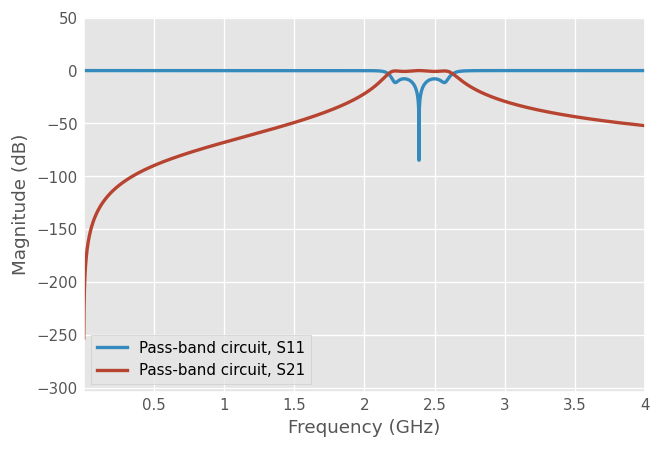

In [ ]:

passband_circuit = circuit.network
passband_circuit.name = 'Pass-band circuit'

passband_circuit.plot_s_db(m=0, n=0, lw=2)
passband_circuit.plot_s_db(m=1, n=0, lw=2)


c) Projecte e simule o filtro usando uma implementação em microstrip coupled lines.



d) Faça uma implementação final do filtro e sua optimização usando uma
implementação em hairpin.



e) Faça a simulação electromagnética do layout do filtro e compare os resultados
obtidos.
Nota: Ver livros “Microwave Engineering”, David M. Pozar e “HF Filter Design and
Computer Simulation”, Randall W. Rhea.